# Variability due to dynamical or property change?
using scaling from Beutel & Allen 2024 to see what the contributors to variability are for Haro Region and Puget Sound

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

## Functions

In [2]:
########
# MATH #
########

def decomp(data,base):
    # slight variation in euation from other attribution file
    # not dividing by transport - so looking at flux of a property instead of just mean property change
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltX':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempX':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOX':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TAX':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3X':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICX':np.zeros(8),'DICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(base.transport[1:])
    df['saltQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.salt[1:]
    df['saltX'] = (data.salt[1:]-base.salt[1:])*(data.transport[1:]-base.transport[1:])
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(base.transport[1:])
    df['tempQ'] = ((data.transport[1:])  - (base.transport[1:]))*base.temp[1:]
    df['tempX'] = (data.temp[1:]-base.temp[1:])*(data.transport[1:]-base.transport[1:])
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(base.transport[1:])
    df['DOQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DO[1:]
    df['DOX'] = (data.DO[1:]-base.DO[1:])*(data.transport[1:]-base.transport[1:])
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(base.transport[1:])
    df['TAQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.TA[1:]
    df['TAX'] = (data.TA[1:]-base.TA[1:])*(data.transport[1:]-base.transport[1:])
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(base.transport[1:])
    df['DICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base.DIC[1:]
    df['DICX'] = (data.DIC[1:]-base.DIC[1:])*(data.transport[1:]-base.transport[1:])
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(base.transport[1:])
    df['NO3Q'] = ((data.transport[1:]) - (base.transport[1:]))*base.NO3[1:]
    df['NO3X'] = (data.NO3[1:]-base.NO3[1:])*(data.transport[1:]-base.transport[1:])
    df['NO3SUM'] = df.NO3P + df.NO3Q

    # TA-DIC
    df['TADICP'] = (data['TA-DIC'][1:] - base['TA-DIC'][1:])*(base.transport[1:])
    df['TADICQ'] = ((data.transport[1:]) - (base.transport[1:]))*base['TA-DIC'][1:]
    df['TADICX'] = (data['TA-DIC'][1:]-base['TA-DIC'][1:])*(data.transport[1:]-base.transport[1:])
    df['TADICSUM'] = df.TADICP + df.TADICQ

    return df
    

In [3]:
############
# PLOTTING #
############
def combined_stacked_bar(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['darkviolet','magenta', 'mediumseagreen','midnightblue','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax.set_yticklabels(list(set(df.year)),fontsize=8)

    
    if str(type(ax2)) == "<class 'matplotlib.axes._axes.Axes'>":
        # Ensure both axes share the same y-axis
        ax2.sharey(ax)
        # Hide y-tick labels on ax2
        ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()

## Haro Region

In [6]:
all14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2014.csv')
all15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2015.csv')
all16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2016.csv')
all17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2017.csv')
all18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2018.csv')
all19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2019.csv')
all20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2020.csv')
all21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2021.csv')
all22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2022.csv')
all23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2023.csv')

In [7]:
d = {'2014':all14.transport[1:],'2015':all15.transport[1:],
     '2016':all16.transport[1:],'2017':all17.transport[1:],'2018':all18.transport[1:],
     '2019':all19.transport[1:],'2020':all20.transport[1:],'2021':all21.transport[1:],
     '2022':all22.transport[1:],'2023':all23.transport[1:]}
all = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

In [8]:
all['section'] = ['cuc','offd','offs','north','south','fresh','loop']

In [9]:
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,2.462073e+08,2.464463e+08,2.231439e+08,3.086597e+08,3.027574e+08,2.470653e+08,2.976967e+08,2.951705e+08,3.676508e+08,2.923004e+08,cuc
2,1.975970e+08,2.592791e+08,2.491655e+08,1.760029e+08,1.991930e+08,2.586149e+08,2.462440e+08,1.908299e+08,1.631523e+08,1.553563e+08,offd
3,5.155185e+07,1.100921e+08,6.128392e+07,5.998644e+07,5.533254e+07,4.366710e+07,6.613465e+07,3.755567e+07,8.878156e+07,3.926016e+07,offs
4,1.410987e+08,1.607634e+08,1.324742e+08,1.683593e+08,1.727569e+08,2.081716e+08,1.557370e+08,1.650328e+08,1.350801e+08,1.158886e+08,north
5,1.273339e+08,2.446863e+08,2.106232e+08,2.301166e+08,1.670901e+08,2.114636e+08,1.037570e+08,1.539312e+08,1.954030e+08,1.927002e+08,south
6,9.877364e+07,1.077782e+08,9.401023e+07,1.149861e+08,9.222280e+07,7.507590e+07,6.216470e+07,6.385509e+07,8.427596e+07,8.527073e+07,fresh
7,3.607165e+08,4.646745e+08,4.182435e+08,4.863923e+08,4.066038e+08,4.770674e+08,3.894157e+08,4.280312e+08,4.813814e+08,4.243668e+08,loop


In [ ]:
# scale based on water from each water mass reaching Haro
# percentages picked based on which season (upwelling or downwelling) the water mass was dominant
# cuc = deep during both upwelling and downwelling (slightly more during upwelling) = ~30%
# offshore deep = deep upwelling = ~33%
# offshore surface = intermediate upwelling = 46%
# north = intermediate upwelling = 46%
# south = intermediate downwelling = 35%
# south brackish =  surface downwelling = 8%
# loop = 5%

multipliers = np.array([0.3, 0.33, 0.46, 0.46, 0.35, 0.08, 0.05])  # one per row

# Separate numeric columns and non-numeric (like 'section')
numeric_cols = all.columns.difference(['section'])

# Apply the multipliers row-wise
all[numeric_cols] = all[numeric_cols].multiply(multipliers[:, np.newaxis])
all

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,section
1,7.386218e+07,7.393389e+07,6.694318e+07,9.259792e+07,9.082722e+07,7.411960e+07,8.930901e+07,8.855114e+07,1.102952e+08,8.769012e+07,cuc
2,6.520702e+07,8.556211e+07,8.222462e+07,5.808096e+07,6.573369e+07,8.534292e+07,8.126052e+07,6.297387e+07,5.384027e+07,5.126759e+07,offd
3,2.371385e+07,5.064238e+07,2.819061e+07,2.759376e+07,2.545297e+07,2.008687e+07,3.042194e+07,1.727561e+07,4.083952e+07,1.805968e+07,offs
4,6.490539e+07,7.395115e+07,6.093812e+07,7.744529e+07,7.946817e+07,9.575896e+07,7.163903e+07,7.591507e+07,6.213683e+07,5.330874e+07,north
5,4.456688e+07,8.564019e+07,7.371814e+07,8.054082e+07,5.848155e+07,7.401225e+07,3.631494e+07,5.387591e+07,6.839105e+07,6.744505e+07,south
6,7.901891e+06,8.622254e+06,7.520818e+06,9.198890e+06,7.377824e+06,6.006072e+06,4.973176e+06,5.108407e+06,6.742077e+06,6.821658e+06,fresh
7,1.803582e+08,2.323373e+08,2.091217e+08,2.431962e+08,2.033019e+08,2.385337e+08,1.947079e+08,2.140156e+08,2.406907e+08,2.121834e+08,loop


In [12]:
all14['transport'] = np.append(np.sum(all14.transport[1:]*multipliers),np.array(all14.transport[1:]*multipliers))
all15['transport'] = np.append(np.sum(all15.transport[1:]*multipliers),np.array(all15.transport[1:]*multipliers))
all16['transport'] = np.append(np.sum(all16.transport[1:]*multipliers),np.array(all16.transport[1:]*multipliers))
all17['transport'] = np.append(np.sum(all17.transport[1:]*multipliers),np.array(all17.transport[1:]*multipliers))
all18['transport'] = np.append(np.sum(all18.transport[1:]*multipliers),np.array(all18.transport[1:]*multipliers))
all19['transport'] = np.append(np.sum(all19.transport[1:]*multipliers),np.array(all19.transport[1:]*multipliers))
all20['transport'] = np.append(np.sum(all20.transport[1:]*multipliers),np.array(all20.transport[1:]*multipliers))
all21['transport'] = np.append(np.sum(all21.transport[1:]*multipliers),np.array(all21.transport[1:]*multipliers))
all22['transport'] = np.append(np.sum(all22.transport[1:]*multipliers),np.array(all22.transport[1:]*multipliers))
all23['transport'] = np.append(np.sum(all23.transport[1:]*multipliers),np.array(all23.transport[1:]*multipliers))


In [13]:
# add [TA-DIC] column
files = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [ ]:
lcom = [113+161+19+18,143+144+60+46,149+158+19+19,198+156+19+20,
        91+128+88+48,163+193+19+29,53+244+19+25,82+189+42+21,
        105+117+137+20,176+136+19+20] # length of each "year"

In [15]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([all14.transport*lcom[0],all15.transport*lcom[1],all16.transport*lcom[2],all17.transport*lcom[3],all18.transport*lcom[4],
                          all19.transport*lcom[5],all20.transport*lcom[6],all21.transport*lcom[7],all22.transport*lcom[8],all23.transport*lcom[9]],axis=0),
     'salt':np.mean([all14.salt,all15.salt,all16.salt,all17.salt,all18.salt,all19.salt,all20.salt,all21.salt,all22.salt,all23.salt],axis=0),
     'temp':np.mean([all14.temp,all15.temp,all16.temp,all17.temp,all18.temp,all19.temp,all20.temp,all21.temp,all22.temp,all23.temp],axis=0),
     'DO':np.mean([all14.DO,all15.DO,all16.DO,all17.DO,all18.DO,all19.DO,all20.DO,all21.DO,all22.DO,all23.DO],axis=0),
     'NO3':np.mean([all14.NO3,all15.NO3,all16.NO3,all17.NO3,all18.NO3,all19.NO3,all20.NO3,all21.NO3,all22.NO3,all23.NO3],axis=0),
     'TA':np.mean([all14.TA,all15.TA,all16.TA,all17.TA,all18.TA,all19.TA,all20.TA,all21.TA,all22.TA,all23.TA],axis=0),
     'DIC':np.mean([all14.DIC,all15.DIC,all16.DIC,all17.DIC,all18.DIC,all19.DIC,all20.DIC,all21.DIC,all22.DIC,all23.DIC],axis=0),
     'TA-DIC':np.mean([all14['[TA-DIC]'],all15['[TA-DIC]'],all16['[TA-DIC]'],all17['[TA-DIC]'],all18['[TA-DIC]'],all19['[TA-DIC]'],all20['[TA-DIC]'],all21['[TA-DIC]'],all22['[TA-DIC]'],all23['[TA-DIC]']],axis=0)}
all_b = pd.DataFrame(d)

all_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC
0,salish,1.966907e+11,32.992956,7.690263,124.157593,28.861600,2276.186625,2246.839051,29.347574
1,cuc,3.063131e+10,33.844661,6.519460,66.533519,36.526207,2320.085505,2320.881654,-0.796148
2,off_d,2.500561e+10,33.734220,6.686667,89.369098,33.650884,2312.313263,2296.522275,15.790988
3,off_s,1.029595e+10,32.835558,8.832818,215.770443,15.595599,2266.865717,2153.315142,113.550575
4,north,2.596516e+10,33.218864,7.637437,154.908330,23.989951,2284.711811,2221.949007,62.762804
5,south,2.352355e+10,32.864380,9.404059,200.422824,17.840091,2270.520067,2171.151849,99.368218
6,fresh,2.545317e+09,30.039493,10.071364,292.972139,7.480471,2160.307036,1988.168208,172.138828
7,loop,7.872376e+10,32.012657,8.525796,173.457623,27.562427,2228.227657,2183.958451,44.269206


In [16]:
all14.transport = all14.transport*lcom[0]
all15.transport = all15.transport*lcom[1]
all16.transport = all16.transport*lcom[2]
all17.transport = all17.transport*lcom[3]
all18.transport = all18.transport*lcom[4]
all19.transport = all19.transport*lcom[5]
all20.transport = all20.transport*lcom[6]
all21.transport = all21.transport*lcom[7]
all22.transport = all22.transport*lcom[8]
all23.transport = all23.transport*lcom[9]

In [17]:
# math! 
math_all14 = decomp(all14,all_b)[1:]
math_all15 = decomp(all15,all_b)[1:]
math_all16 = decomp(all16,all_b)[1:]
math_all17 = decomp(all17,all_b)[1:]
math_all18 = decomp(all18,all_b)[1:]
math_all19 = decomp(all19,all_b)[1:]
math_all20 = decomp(all20,all_b)[1:]
math_all21 = decomp(all21,all_b)[1:]
math_all22 = decomp(all22,all_b)[1:]
math_all23 = decomp(all23,all_b)[1:]


# add year 
math_all14['year'] = 2014
math_all15['year'] = 2015
math_all16['year'] = 2016
math_all17['year'] = 2017
math_all18['year'] = 2018
math_all19['year'] = 2019
math_all20['year'] = 2020
math_all21['year'] = 2021
math_all22['year'] = 2022
math_all23['year'] = 2023


In [18]:
# SALT

df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.001 (0.001), Q mean = 0.018 (0.019), X mean = 0.0 (0.0), mean total = 0.019 (0.019), std% = 98.0
off_s: P mean = 0.001 (0.001), Q mean = 0.13 (0.097), X mean = 0.0 (0.0), mean total = 0.131 (0.097), std% = 74.3
north: P mean = 0.003 (0.002), Q mean = 0.198 (0.118), X mean = 0.001 (0.0), mean total = 0.201 (0.119), std% = 58.9
south: P mean = 0.001 (0.001), Q mean = 0.264 (0.176), X mean = 0.0 (0.0), mean total = 0.265 (0.175), std% = 66.10000000000001
cuc: P mean = 0.001 (0.0), Q mean = 0.168 (0.155), X mean = 0.0 (0.0), mean total = 0.169 (0.156), std% = 92.30000000000001
off_d: P mean = 0.001 (0.001), Q mean = 0.213 (0.077), X mean = 0.0 (0.0), mean total = 0.215 (0.077), std% = 36.0
total P mean = 0.0079 (0.0036), Q mean = 0.9908, (0.0038)


In [19]:
# TEMP

df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.01 (0.006), Q mean = 0.02 (0.02), X mean = 0.002 (0.002), mean total = 0.032 (0.023), std% = 73.2
off_s: P mean = 0.021 (0.018), Q mean = 0.116 (0.082), X mean = 0.006 (0.007), mean total = 0.144 (0.091), std% = 63.4
north: P mean = 0.017 (0.012), Q mean = 0.16 (0.102), X mean = 0.003 (0.002), mean total = 0.18 (0.105), std% = 58.599999999999994
south: P mean = 0.069 (0.021), Q mean = 0.252 (0.164), X mean = 0.017 (0.012), mean total = 0.338 (0.171), std% = 50.5
cuc: P mean = 0.018 (0.01), Q mean = 0.113 (0.108), X mean = 0.002 (0.003), mean total = 0.133 (0.11), std% = 82.8
off_d: P mean = 0.024 (0.013), Q mean = 0.145 (0.056), X mean = 0.004 (0.003), mean total = 0.173 (0.063), std% = 36.4
total P mean = 0.1594 (0.0503), Q mean = 0.8058, (0.0535)


In [20]:
# DO

df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.003 (0.003), Q mean = 0.029 (0.029), X mean = 0.0 (0.001), mean total = 0.032 (0.028), std% = 88.2
off_s: P mean = 0.009 (0.008), Q mean = 0.15 (0.108), X mean = 0.002 (0.002), mean total = 0.16 (0.106), std% = 66.2
north: P mean = 0.066 (0.06), Q mean = 0.171 (0.115), X mean = 0.01 (0.009), mean total = 0.248 (0.135), std% = 54.6
south: P mean = 0.055 (0.045), Q mean = 0.271 (0.157), X mean = 0.014 (0.013), mean total = 0.341 (0.18), std% = 52.7
cuc: P mean = 0.02 (0.015), Q mean = 0.062 (0.063), X mean = 0.003 (0.005), mean total = 0.086 (0.074), std% = 86.2
off_d: P mean = 0.026 (0.021), Q mean = 0.102 (0.042), X mean = 0.005 (0.005), mean total = 0.133 (0.056), std% = 42.4
total P mean = 0.1793 (0.0759), Q mean = 0.7861, (0.0792)


In [21]:
# NO3

df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))


fresh: P mean = 0.007 (0.008), Q mean = 0.005 (0.006), X mean = 0.002 (0.003), mean total = 0.014 (0.015), std% = 105.5
off_s: P mean = 0.011 (0.009), Q mean = 0.068 (0.055), X mean = 0.002 (0.003), mean total = 0.082 (0.053), std% = 65.2
north: P mean = 0.051 (0.045), Q mean = 0.154 (0.092), X mean = 0.008 (0.007), mean total = 0.212 (0.107), std% = 50.2
south: P mean = 0.046 (0.025), Q mean = 0.165 (0.121), X mean = 0.011 (0.009), mean total = 0.222 (0.136), std% = 61.1
cuc: P mean = 0.017 (0.013), Q mean = 0.188 (0.167), X mean = 0.002 (0.003), mean total = 0.207 (0.17), std% = 82.19999999999999
off_d: P mean = 0.023 (0.02), Q mean = 0.236 (0.09), X mean = 0.004 (0.004), mean total = 0.263 (0.098), std% = 37.4
total P mean = 0.155 (0.0615), Q mean = 0.8155, (0.0634)


In [22]:
# TA

df = pd.concat([math_all14[['year','section','TAP','TAQ','TAX']][:-1],math_all15[['year','section','TAP','TAQ','TAX']][:-1],
    math_all16[['year','section','TAP','TAQ','TAX']][:-1],math_all17[['year','section','TAP','TAQ','TAX']][:-1],
    math_all18[['year','section','TAP','TAQ','TAX']][:-1],math_all19[['year','section','TAP','TAQ','TAX']][:-1],
    math_all20[['year','section','TAP','TAQ','TAX']][:-1],math_all21[['year','section','TAP','TAQ','TAX']][:-1],
    math_all22[['year','section','TAP','TAQ','TAX']][:-1],math_all23[['year','section','TAP','TAQ','TAX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.001 (0.0), Q mean = 0.019 (0.02), X mean = 0.0 (0.0), mean total = 0.02 (0.02), std% = 100.2
off_s: P mean = 0.001 (0.001), Q mean = 0.13 (0.097), X mean = 0.0 (0.0), mean total = 0.131 (0.098), std% = 74.4
north: P mean = 0.003 (0.001), Q mean = 0.198 (0.119), X mean = 0.0 (0.0), mean total = 0.201 (0.119), std% = 59.199999999999996
south: P mean = 0.001 (0.001), Q mean = 0.265 (0.176), X mean = 0.0 (0.0), mean total = 0.266 (0.176), std% = 66.10000000000001
cuc: P mean = 0.001 (0.001), Q mean = 0.167 (0.155), X mean = 0.0 (0.0), mean total = 0.169 (0.156), std% = 92.4
off_d: P mean = 0.001 (0.002), Q mean = 0.213 (0.077), X mean = 0.0 (0.0), mean total = 0.214 (0.077), std% = 35.9
total P mean = 0.0071 (0.0033), Q mean = 0.9917, (0.0034)


In [23]:
# DIC

df = pd.concat([math_all14[['year','section','DICP','DICQ','DICX']][:-1],math_all15[['year','section','DICP','DICQ','DICX']][:-1],
    math_all16[['year','section','DICP','DICQ','DICX']][:-1],math_all17[['year','section','DICP','DICQ','DICX']][:-1],
    math_all18[['year','section','DICP','DICQ','DICX']][:-1],math_all19[['year','section','DICP','DICQ','DICX']][:-1],
    math_all20[['year','section','DICP','DICQ','DICX']][:-1],math_all21[['year','section','DICP','DICQ','DICX']][:-1],
    math_all22[['year','section','DICP','DICQ','DICX']][:-1],math_all23[['year','section','DICP','DICQ','DICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.001 (0.001), Q mean = 0.018 (0.018), X mean = 0.0 (0.0), mean total = 0.019 (0.019), std% = 101.0
off_s: P mean = 0.002 (0.001), Q mean = 0.126 (0.094), X mean = 0.0 (0.0), mean total = 0.127 (0.094), std% = 74.1
north: P mean = 0.006 (0.007), Q mean = 0.195 (0.117), X mean = 0.001 (0.001), mean total = 0.202 (0.118), std% = 58.3
south: P mean = 0.005 (0.003), Q mean = 0.258 (0.173), X mean = 0.001 (0.001), mean total = 0.264 (0.173), std% = 65.5
cuc: P mean = 0.002 (0.002), Q mean = 0.169 (0.156), X mean = 0.0 (0.001), mean total = 0.171 (0.157), std% = 91.7
off_d: P mean = 0.003 (0.002), Q mean = 0.214 (0.078), X mean = 0.0 (0.0), mean total = 0.217 (0.079), std% = 36.4
total P mean = 0.0181 (0.0094), Q mean = 0.9787, (0.0097)


In [24]:
# TA-DIC

df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']

regions = list(set(df.section))

for region in regions:
    b = df.section == region
    print("{}: P mean = {} ({}), Q mean = {} ({}), X mean = {} ({}), mean total = {} ({}), std% = {}".format(
        region,np.round(np.mean(df.normP[b]),3),np.round(np.std(df.normP[b]),3),
        np.round(np.mean(df.normQ[b]),3),np.round(np.std(df.normQ[b]),3),
        np.round(np.mean(df.normX[b]),3),np.round(np.std(df.normX[b]),3),
        np.round(np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3),
        np.round(np.std(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0))/np.mean(np.sum([df.normP[b],df.normQ[b],df.normX[b]],axis=0)),3)*100))

years = list(set(df.year))
Psum = [np.sum(df.normP[df.year == y]) for y in years]
Qsum = [np.sum(df.normQ[df.year == y]) for y in years]
Xsum = [np.sum(df.normX[df.year == y]) for y in years]
print("total P mean = {} ({}), Q mean = {}, ({})".format(np.round(np.mean(Psum),4),np.round(np.std(Psum),4),np.round(np.mean(Qsum),4),np.round(np.std(Qsum),4)))

fresh: P mean = 0.015 (0.012), Q mean = 0.032 (0.032), X mean = 0.003 (0.004), mean total = 0.05 (0.044), std% = 86.7
off_s: P mean = 0.025 (0.022), Q mean = 0.153 (0.111), X mean = 0.006 (0.007), mean total = 0.184 (0.112), std% = 60.8
north: P mean = 0.087 (0.098), Q mean = 0.135 (0.091), X mean = 0.013 (0.011), mean total = 0.235 (0.14), std% = 59.5
south: P mean = 0.115 (0.072), Q mean = 0.265 (0.167), X mean = 0.025 (0.022), mean total = 0.405 (0.175), std% = 43.2
cuc: P mean = 0.039 (0.021), Q mean = 0.001 (0.002), X mean = 0.007 (0.008), mean total = 0.047 (0.03), std% = 63.0
off_d: P mean = 0.036 (0.034), Q mean = 0.035 (0.015), X mean = 0.008 (0.01), mean total = 0.079 (0.054), std% = 68.2
total P mean = 0.3164 (0.1284), Q mean = 0.6222, (0.1305)


/tmp/ipykernel_230268/3776170382.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


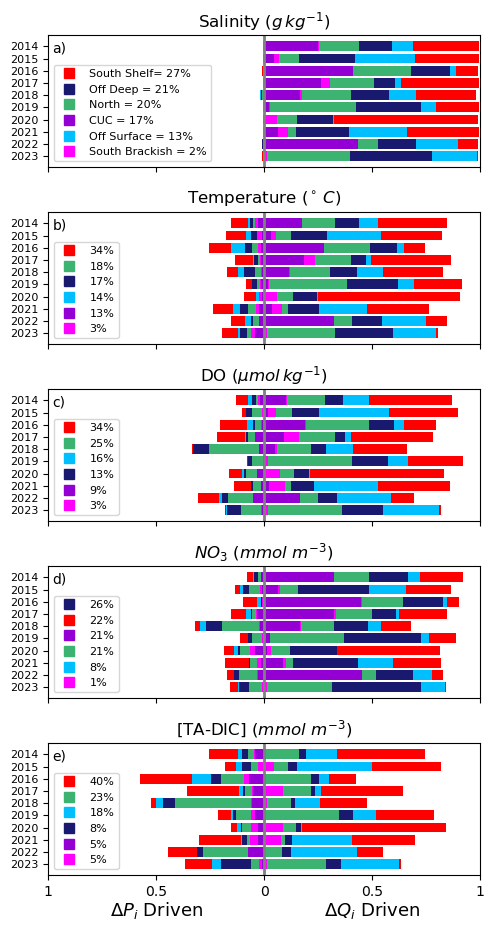

In [ ]:
# with percentages included in the figure 
sections = ['cuc','off_d','off_s','north','south','fresh']

# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)
ax1.set_title('Salinity ($g\,kg^{-1}$)')
   
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'Off Deep = {}%'.format(perc[1]), 'North = {}%'.format(perc[3]), 'CUC = {}%'.format(perc[0]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','midnightblue','mediumseagreen','darkviolet','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)
ax3.set_title('Temperature ($^\circ\,C$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[1]), '{}%'.format(perc[2]), '{}%'.format(perc[0]),  
                   '{}%'.format(perc[5])]
colours = ['red','mediumseagreen','midnightblue','deepskyblue','darkviolet','magenta',]
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax3.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)
ax5.set_title('DO ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[1]), 
                     '{}%'.format(perc[0]),'{}%'.format(perc[5])]
colours = ['red','mediumseagreen','deepskyblue','midnightblue','darkviolet','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)
ax7.set_title('$NO_3$ ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[1]), '{}%'.format(perc[4]), '{}%'.format(perc[0]), 
                   '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['midnightblue','red','darkviolet','mediumseagreen','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9,False)
ax9.set_title('[TA-DIC] ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[2]),
                   '{}%'.format(perc[1]),  '{}%'.format(perc[0]),'{}%'.format(perc[5])]
colours = ['red','mediumseagreen','deepskyblue','midnightblue','darkviolet','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax9.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=10)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')

## Puget Sound

In [30]:
all14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2014.csv')
all15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2015.csv')
all16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2016.csv')
all17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2017.csv')
all18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2018.csv')
all19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2019.csv')
all20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2020.csv')
all21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2021.csv')
all22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2022.csv')
all23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/combo_2023.csv')

d = {'2014':all14.transport[1:],'2015':all15.transport[1:],
     '2016':all16.transport[1:],'2017':all17.transport[1:],'2018':all18.transport[1:],
     '2019':all19.transport[1:],'2020':all20.transport[1:],'2021':all21.transport[1:],
     '2022':all22.transport[1:],'2023':all23.transport[1:]}
all = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

all['section'] = ['cuc','offd','offs','north','south','fresh','loop']

In [ ]:
# scale based on water from each water mass reaching Haro
# percentages picked based on which season (upwelling or downwelling) the water mass was dominant
# cuc = deep during both upwelling and downwelling (slightly more during upwelling) = 6%
# offshore deep = deep upwelling = 6%
# offshore surface = intermediate upwelling = 10%
# north = intermediate upwelling = 10%
# south = intermediate downwelling = 10%
# south brackish =  surface downwelling = 5%
# loop = 5%

multipliers = np.array([0.06, 0.06, 0.1, 0.1, 0.1, 0.05, 0.05])  # one per row

# Separate numeric columns and non-numeric (like 'section')
numeric_cols = all.columns.difference(['section'])

# Apply the multipliers row-wise
all[numeric_cols] = all[numeric_cols].multiply(multipliers[:, np.newaxis])

all14['transport'] = np.append(np.sum(all14.transport[1:]*multipliers),np.array(all14.transport[1:]*multipliers))
all15['transport'] = np.append(np.sum(all15.transport[1:]*multipliers),np.array(all15.transport[1:]*multipliers))
all16['transport'] = np.append(np.sum(all16.transport[1:]*multipliers),np.array(all16.transport[1:]*multipliers))
all17['transport'] = np.append(np.sum(all17.transport[1:]*multipliers),np.array(all17.transport[1:]*multipliers))
all18['transport'] = np.append(np.sum(all18.transport[1:]*multipliers),np.array(all18.transport[1:]*multipliers))
all19['transport'] = np.append(np.sum(all19.transport[1:]*multipliers),np.array(all19.transport[1:]*multipliers))
all20['transport'] = np.append(np.sum(all20.transport[1:]*multipliers),np.array(all20.transport[1:]*multipliers))
all21['transport'] = np.append(np.sum(all21.transport[1:]*multipliers),np.array(all21.transport[1:]*multipliers))
all22['transport'] = np.append(np.sum(all22.transport[1:]*multipliers),np.array(all22.transport[1:]*multipliers))
all23['transport'] = np.append(np.sum(all23.transport[1:]*multipliers),np.array(all23.transport[1:]*multipliers))

In [32]:
# add [TA-DIC] column
files = [all14,all15,all16,all17,all18,all19,all20,all21,all22,all23]

for file in files:
    file['TA-DIC'] = file.TA - file.DIC

In [33]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([all14.transport*lcom[0],all15.transport*lcom[1],all16.transport*lcom[2],all17.transport*lcom[3],all18.transport*lcom[4],
                          all19.transport*lcom[5],all20.transport*lcom[6],all21.transport*lcom[7],all22.transport*lcom[8],all23.transport*lcom[9]],axis=0),
     'salt':np.mean([all14.salt,all15.salt,all16.salt,all17.salt,all18.salt,all19.salt,all20.salt,all21.salt,all22.salt,all23.salt],axis=0),
     'temp':np.mean([all14.temp,all15.temp,all16.temp,all17.temp,all18.temp,all19.temp,all20.temp,all21.temp,all22.temp,all23.temp],axis=0),
     'DO':np.mean([all14.DO,all15.DO,all16.DO,all17.DO,all18.DO,all19.DO,all20.DO,all21.DO,all22.DO,all23.DO],axis=0),
     'NO3':np.mean([all14.NO3,all15.NO3,all16.NO3,all17.NO3,all18.NO3,all19.NO3,all20.NO3,all21.NO3,all22.NO3,all23.NO3],axis=0),
     'TA':np.mean([all14.TA,all15.TA,all16.TA,all17.TA,all18.TA,all19.TA,all20.TA,all21.TA,all22.TA,all23.TA],axis=0),
     'DIC':np.mean([all14.DIC,all15.DIC,all16.DIC,all17.DIC,all18.DIC,all19.DIC,all20.DIC,all21.DIC,all22.DIC,all23.DIC],axis=0),
     'TA-DIC':np.mean([all14['[TA-DIC]'],all15['[TA-DIC]'],all16['[TA-DIC]'],all17['[TA-DIC]'],all18['[TA-DIC]'],all19['[TA-DIC]'],all20['[TA-DIC]'],all21['[TA-DIC]'],all22['[TA-DIC]'],all23['[TA-DIC]']],axis=0)}
all_b = pd.DataFrame(d)

all_b

,section,transport,salt,temp,DO,NO3,TA,DIC,TA-DIC
0,salish,3.473980e+10,32.992956,7.690263,124.157593,28.861600,2276.186625,2246.839051,29.347574
1,cuc,6.126262e+09,33.844661,6.519460,66.533519,36.526207,2320.085505,2320.881654,-0.796148
2,off_d,4.546474e+09,33.734220,6.686667,89.369098,33.650884,2312.313263,2296.522275,15.790988
3,off_s,2.238251e+09,32.835558,8.832818,215.770443,15.595599,2266.865717,2153.315142,113.550575
4,north,5.644600e+09,33.218864,7.637437,154.908330,23.989951,2284.711811,2221.949007,62.762804
5,south,6.721013e+09,32.864380,9.404059,200.422824,17.840091,2270.520067,2171.151849,99.368218
6,fresh,1.590823e+09,30.039493,10.071364,292.972139,7.480471,2160.307036,1988.168208,172.138828
7,loop,7.872376e+09,32.012657,8.525796,173.457623,27.562427,2228.227657,2183.958451,44.269206


In [34]:
all14.transport = all14.transport*lcom[0]
all15.transport = all15.transport*lcom[1]
all16.transport = all16.transport*lcom[2]
all17.transport = all17.transport*lcom[3]
all18.transport = all18.transport*lcom[4]
all19.transport = all19.transport*lcom[5]
all20.transport = all20.transport*lcom[6]
all21.transport = all21.transport*lcom[7]
all22.transport = all22.transport*lcom[8]
all23.transport = all23.transport*lcom[9]

In [35]:
# math! 
math_all14 = decomp(all14,all_b)[1:]
math_all15 = decomp(all15,all_b)[1:]
math_all16 = decomp(all16,all_b)[1:]
math_all17 = decomp(all17,all_b)[1:]
math_all18 = decomp(all18,all_b)[1:]
math_all19 = decomp(all19,all_b)[1:]
math_all20 = decomp(all20,all_b)[1:]
math_all21 = decomp(all21,all_b)[1:]
math_all22 = decomp(all22,all_b)[1:]
math_all23 = decomp(all23,all_b)[1:]


# add year 
math_all14['year'] = 2014
math_all15['year'] = 2015
math_all16['year'] = 2016
math_all17['year'] = 2017
math_all18['year'] = 2018
math_all19['year'] = 2019
math_all20['year'] = 2020
math_all21['year'] = 2021
math_all22['year'] = 2022
math_all23['year'] = 2023

/tmp/ipykernel_230268/3776170382.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.75, -0.35, '$\\Delta Q_i$ Driven')

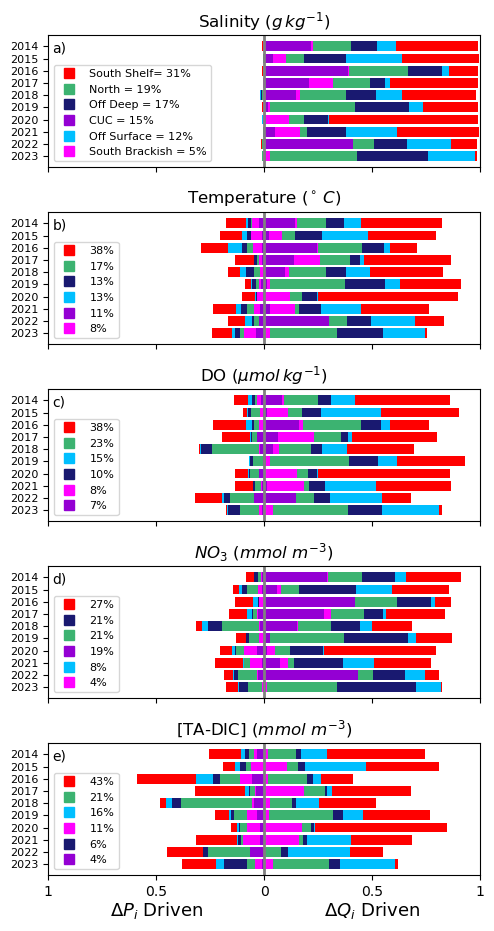

In [37]:
# with percentages included in the figure 
sections = ['cuc','off_d','off_s','north','south','fresh']

# Plotting
fig = plt.figure(constrained_layout=True, figsize=[5,9])
gs = GridSpec(5, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[3,0])
ax9 = fig.add_subplot(gs[4,0])

# SALINITY
df = pd.concat([math_all14[['year','section','saltP','saltQ','saltX']][:-1],math_all15[['year','section','saltP','saltQ','saltX']][:-1],
    math_all16[['year','section','saltP','saltQ','saltX']][:-1],math_all17[['year','section','saltP','saltQ','saltX']][:-1],
    math_all18[['year','section','saltP','saltQ','saltX']][:-1],math_all19[['year','section','saltP','saltQ','saltX']][:-1],
    math_all20[['year','section','saltP','saltQ','saltX']][:-1],math_all21[['year','section','saltP','saltQ','saltX']][:-1],
    math_all22[['year','section','saltP','saltQ','saltX']][:-1],math_all23[['year','section','saltP','saltQ','saltX']][:-1]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,False)
ax1.set_title('Salinity ($g\,kg^{-1}$)')
   
df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['South Shelf= {}%'.format(perc[4]), 'North = {}%'.format(perc[3]), 'Off Deep = {}%'.format(perc[1]), 'CUC = {}%'.format(perc[0]),
           'Off Surface = {}%'.format(perc[2]), 'South Brackish = {}%'.format(perc[5])]
colours = ['red','mediumseagreen','midnightblue','darkviolet','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TEMPERATURE
df = pd.concat([math_all14[['year','section','tempP','tempQ','tempX']][:-1],math_all15[['year','section','tempP','tempQ','tempX']][:-1],
    math_all16[['year','section','tempP','tempQ','tempX']][:-1],math_all17[['year','section','tempP','tempQ','tempX']][:-1],
    math_all18[['year','section','tempP','tempQ','tempX']][:-1],math_all19[['year','section','tempP','tempQ','tempX']][:-1],
    math_all20[['year','section','tempP','tempQ','tempX']][:-1],math_all21[['year','section','tempP','tempQ','tempX']][:-1],
    math_all22[['year','section','tempP','tempQ','tempX']][:-1],math_all23[['year','section','tempP','tempQ','tempX']][:-1]])
combined_stacked_bar(df,'Temperature (degC)',ax3,False)
ax3.set_title('Temperature ($^\circ\,C$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[1]), '{}%'.format(perc[2]), '{}%'.format(perc[0]),  
                   '{}%'.format(perc[5])]
colours = ['red','mediumseagreen','midnightblue','deepskyblue','darkviolet','magenta',]
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax3.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# DO
df = pd.concat([math_all14[['year','section','DOP','DOQ','DOX']][:-1],math_all15[['year','section','DOP','DOQ','DOX']][:-1],
    math_all16[['year','section','DOP','DOQ','DOX']][:-1],math_all17[['year','section','DOP','DOQ','DOX']][:-1],
    math_all18[['year','section','DOP','DOQ','DOX']][:-1],math_all19[['year','section','DOP','DOQ','DOX']][:-1],
    math_all20[['year','section','DOP','DOQ','DOX']][:-1],math_all21[['year','section','DOP','DOQ','DOX']][:-1],
    math_all22[['year','section','DOP','DOQ','DOX']][:-1],math_all23[['year','section','DOP','DOQ','DOX']][:-1]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,False)
ax5.set_title('DO ($\mu mol \, kg^{-1}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[2]), '{}%'.format(perc[1]),'{}%'.format(perc[5]), 
                     '{}%'.format(perc[0])]
colours = ['red','mediumseagreen','deepskyblue','midnightblue','magenta','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax5.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# NO3
df = pd.concat([math_all14[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all15[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all16[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all17[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all18[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all19[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all20[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all21[['year','section','NO3P','NO3Q','NO3X']][:-1],
    math_all22[['year','section','NO3P','NO3Q','NO3X']][:-1],math_all23[['year','section','NO3P','NO3Q','NO3X']][:-1]])
combined_stacked_bar(df,'NO3 (uM)',ax7,False)
ax7.set_title('$NO_3$ ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]),'{}%'.format(perc[1]), '{}%'.format(perc[3]), '{}%'.format(perc[0]), 
                    '{}%'.format(perc[2]), '{}%'.format(perc[5])]
colours = ['red','midnightblue','mediumseagreen','darkviolet','deepskyblue','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax7.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

# TA-DIC
df = pd.concat([math_all14[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all15[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all16[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all17[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all18[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all19[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all20[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all21[['year','section','TADICP','TADICQ','TADICX']][:-1],
    math_all22[['year','section','TADICP','TADICQ','TADICX']][:-1],math_all23[['year','section','TADICP','TADICQ','TADICX']][:-1]])
combined_stacked_bar(df,'[TA-DIC] (uM)',ax9,False)
ax9.set_title('[TA-DIC] ($mmol\,\,m^{-3}$)')

df['absP'] = df[df.columns[2]].abs()
df['absQ'] = df[df.columns[3]].abs()
df['absX'] = df[df.columns[4]].abs()
df['total_abs'] = df.groupby('year')[['absP', 'absQ','absX']].transform('sum').sum(axis=1)
df['normP'] = df['absP'] / df['total_abs']
df['normQ'] = df['absQ'] / df['total_abs']
df['normX'] = df['absX'] / df['total_abs']
perc = [int(np.round(np.mean(np.sum([df.normP[df.section==region],df.normQ[df.section==region],df.normX[df.section==region]],axis=0)),2)*100) for region in sections]

legend_handles = []
regions = ['{}%'.format(perc[4]), '{}%'.format(perc[3]), '{}%'.format(perc[2]),
                  '{}%'.format(perc[5]), '{}%'.format(perc[1]),  '{}%'.format(perc[0])]
colours = ['red','mediumseagreen','deepskyblue','magenta','midnightblue','darkviolet']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
ax9.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)

ax9.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=10)
ax3.text(.01, .85, 'b)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=10)
ax5.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=10)
ax7.text(.01, .85, 'd)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=10)
ax9.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=10)

ax9.text(.25, -0.35, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)
ax9.text(.75, -0.35, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax9.transAxes, fontsize=13)


# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution_flux.pdf", bbox_inches='tight')